In [1]:
# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements.  See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership.  The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License.  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied.  See the License for the
# specific language governing permissions and limitations
# under the License. 

import numpy as np
import matplotlib.pyplot as plt

# Analysis of the Impact of Attenuation on the Spectral Gap of Promised Davies Generators

This Juptyer Notebook is supplemental material to the manuscrpt "Thermal State Preparation via Rounding Promises", which presents a quantum algorithm for preparing thermal Gibbs states. 

Generally, in the analysis of algorithms we care about two things: accuracy of the algorithm output and bounds on the algorithm runtime. The algorithm considered in this work operates by simulating the dynamics of thermalization, which may converge faster or slower depending on the system of interest. This makes a generic bound on runtime very difficult to establish.

So, if we cannot prove fast runtime, then at the very least prove that the result is accurate and demonstrate efficiency through a numerical analysis. Indeed, we can interpret this work as 'moving all the hard-to-prove things' into the runtime so at least the accuracy guarantee is rigorous. Moreover, if we think of  the mixing time $t_\text{mix}$ of the underlying thermalization process as a free parameter, then rigorous analysis of runtime is also possible.

So our numerical analysis must assess the mixing time $t_\text{mix}$ of a partular physical system of interest.

## Objective

The starting point of the method is an ideal Davies generator which represents the thermalization of the system in nature. But the ideal Davies generator's implementation requires perfect energy estimation, which is not possible on a quantum computer. So, instead we modify the ideal Davies generator to define several 'promised Davies generators', which are implementable.

However, the  promised Davies generators demand 'attenuation' of the coupling opertors, which will slow the convergence rate of the algorithm. The purpose of this notebook is to assess the severity of this effect.

## Contents

1. Summary of Imported Scripts
2. Transverse Field Ising Model
3. Lindblad Analysis
 - Promised Davies Generator
 - Ideal Davies Generator
4. Impact of Attenuation on the Promised Davies Generator


## 1. Summary of Imported Scripts

In [2]:
from src.rounding_promises import *
# get_rounding_promise(n,r,side,j)
# make_calJ(promise)
# promise_isometry(eigs,promise)
# get_thermal_state(eigs,beta)
# get_promised_thermal_state(promise, beta)

from src.poly_construction import *
# apply_to_H(f, eigs)
# promised_energy_projector(eigs,x,promise)
# attenuation_operator(eigs,promise,gamma)

from src.lindblad_analysis import *
# get_lindblad(calJ, pi, couplers, beta)
# get_spectral_gap(L)
# get_steady_state(L)
# check_steady_state(L, rho)
# make_couplers(nqubits, eigv)

from src.caching import *
# collect_data(*args, fn=,filename=,nthreads=1,prec=3,timing=True)
# print_available_data(filename, fn)

## 2. Transverse Field Ising Model

As a toy hamiltonian, we consider an `n1` by `n2` grid of qubits with the Hamiltonian:
$$ H = \sum_i v X_i + \sum_{i,j} Z_i Z_j$$
where the $i,j$ sum is over adjacent pairs in the grid (without periodic boundary conditions).

We will be working in the energy eigenbasis of this Hamiltonian, so we might as well diagnalize it. We also shift its spectrum into the interval $[0,1]$.

In [3]:

def ising_model_hamiltonian(n1,n2,v):
    # Takes 2x2 matrix and makes it a matrix
    # on the entire system on qubit i.
    def mat(M,i):
        out = np.eye(2**i)
        out = np.kron(out, M)
        return np.kron(out, np.eye(2**(n1*n2-i-1)))

    idx = lambda i, j: i*n2 + j

    # Assemble the Hamiltonian.
    H = np.zeros((2**(n1*n2),2**(n1*n2)))
    for i in range(n1):
        for j in range(n2):
            # v X_idx term
            H += v * mat(np.array([[0,1],[1,0]]),idx(i,j))
            
            # Z_idx Z_jdx terms 
            if i > 0: # connect to left qubit
                H += mat(np.diag([1,-1]),idx(i,j)) @\
                     mat(np.diag([1,-1]),idx(i-1,j))
            if j > 0: # connect to above qubit
                H += mat(np.diag([1,-1]),idx(i,j)) @\
                     mat(np.diag([1,-1]),idx(i,j-1))

    # Diagonalize
    eigs, eigv = np.linalg.eigh(H)
    eigs -= min(eigs)
    eigs /= max(eigs)
    return eigs,eigv

## 3. Lindblad Analysis

### Ideal Davies Generator

In [4]:
def ideal_davies_generator_gap(beta,eigs,eigv):
    
    couplers = make_couplers(eigv)
    
    # ideal Bohr frequencies
    calJ = {}
    for i in range(len(eigs)):
        for j in range(len(eigs)):
            omega = eigs[i]-eigs[j]
            if omega not in calJ: calJ[omega] = []
            calJ[omega].append((i,j))
    
    pi = lambda x: np.diag([1 if i ==x else 0 for i in range(len(eigs))])
    
    L = get_lindblad(calJ, pi, couplers, beta)
    
    target = get_thermal_state(eigs, beta)

    if not check_steady_state(L, target):
        return "Thermal state is not a steady state."
    
    gap, error = get_spectral_gap(L)

    if error is not None: return error
    
    return gap

### Promised Davies Generator

In [5]:
def promised_davies_generator_gaps(beta,eigs,eigv,n,r,gamma):
    
    # returns a dictionary of two lists of spectral gaps
    out = {
        "left": [],
        "right": []
    }
    
    # Get the couplers on the full Hilbert space
    raw_couplers = make_couplers(eigv)
    
    for side in out.keys():
        for j in range(2**r):
            promise = get_rounding_promise(n,r,side,j)
            
            # Bohr frequencies corresponding to the promise.
            calJ = make_calJ(promise)
            
            # Attenuate the couplers and then project
            # them onto the promised subspace
            iso = promise_isometry(eigs, promise)
           
            atten = attenuation_operator(eigs,promise,gamma)
            couplers = [iso.T @ atten @ coupler @ atten @ iso
                        for coupler in raw_couplers]
            
            pi = lambda x: iso.T @ promised_energy_projector(eigs,x,promise) @ iso
    
            L = get_lindblad(calJ, pi, couplers, beta)
            
            target = get_promised_thermal_state(eigs, promise, beta)
            
            if not check_steady_state(L, target):
                out[side].append("Promised thermal state is not a steady state.")
                continue
            
            gap, error = get_spectral_gap(L)
            
            if error is not None:
                out[side].append(error)
                continue
            
            out[side].append(gap)
    
    return out

## 4. Impact of Attenuation on the Promised Davies Generator

In [6]:
def ising_promised_davies_generator_gaps(n1:int,n2:int,v:float,
                                         beta:float,n:int,r:int,gamma:float):
    eigs, eigv = ising_model_hamiltonian(n1,n2,v)
    return promised_davies_generator_gaps(beta,eigs,eigv,n,r,gamma)


def ising_ideal_davies_generator_gap(n1:int,n2:int,v:float,beta:float):
    eigs, eigv = ising_model_hamiltonian(n1,n2,v)
    return ideal_davies_generator_gap(beta,eigs,eigv)

In [15]:
def plot_mixing_times(n1,n2,v,n,r,beta,gammas):
    
    # Plot ideal inverse spectral gap as a dashed line
    ideal_data = collect_data(n1,n2,v,beta,
                        fn=ising_ideal_davies_generator_gap,
                        filename="data.json",nthreads=8)
    
    ideal_spectral_gap = ideal_data[(n1,n2,v,beta)]
    ideal_tmix = 1/ideal_spectral_gap
    
    plt.plot([min(gammas),max(gammas)],[ideal_tmix, ideal_tmix],
             c="k",linestyle="--")
    
    # Plot promised inverse spectral gaps as a scatter plot
    # plus a solid line for the average
    promised_data = collect_data(n1,n2,v,beta,n,r,gammas,
                    fn=ising_promised_davies_generator_gaps,
                    filename="data.json",nthreads=3)
   
    averages = []
    all_gaps = []
    
    for key,gap_data in promised_data.items():
        gamma = key[-1]
        gap_data = gap_data["left"] + gap_data["right"]
        averages.append((gamma,np.mean([1/Delta for Delta in gap_data])))
        for Delta in gap_data:
            all_gaps.append((gamma,1/Delta))

    plt.scatter(*zip(*all_gaps),c="k")
    plt.plot(*zip(*averages),c="k")

    
    plt.grid()
    plt.title("Impact of Attenuation on the Spectral Gap\n"+\
              "for a Transverse Field Ising Model\n"+
             "on {} x {} Qubits with Field Strength {}\n".format(n1,n2,v)+
             "n = {}, r = {}, $\\beta$ = {}".format(n,r,beta))
    plt.xlabel("Attenuation factor $\\gamma$")
    plt.ylabel("Inverse Spectral Gap 1/$\\Delta$")
    plt.yscale("log")


In [16]:
print_available_data("data.json",ising_promised_davies_generator_gaps)

{'n1': [2], 'n2': [3], 'v': [1.0], 'beta': [1.0], 'n': [3], 'r': [2], 'gamma': [0.025, 0.075, 0.125, 0.175]}
{'n1': [2], 'n2': [3], 'v': [1.0], 'beta': [1.0, 10.0], 'n': [3], 'r': [2], 'gamma': [0.0, 0.05, 0.1, 0.15, 0.2, 0.4]}
{'n1': [2], 'n2': [3], 'v': [1.0], 'beta': [1.0], 'n': [2, 3], 'r': [1], 'gamma': [0.025, 0.075, 0.125, 0.175]}
{'n1': [2], 'n2': [3], 'v': [1.0], 'beta': [1.0, 10.0], 'n': [2, 3], 'r': [1], 'gamma': [0.0, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8]}
{'n1': [2], 'n2': [3], 'v': [1.0], 'beta': [1.0], 'n': [1, 3], 'r': [2], 'gamma': [0.6, 0.8]}
{'n1': [2], 'n2': [3], 'v': [1.0], 'beta': [1.0, 10.0], 'n': [2], 'r': [2], 'gamma': [0.6, 0.8]}
{'n1': [2], 'n2': [2], 'v': [1.0], 'beta': [10.0], 'n': [2], 'r': [2], 'gamma': [0.025, 0.075, 0.125, 0.175]}
{'n1': [2], 'n2': [2], 'v': [1.0], 'beta': [10.0], 'n': [1], 'r': [2], 'gamma': [0.2, 0.4]}
{'n1': [2], 'n2': [2], 'v': [1.0], 'beta': [10.0], 'n': [1], 'r': [2, 3], 'gamma': [0.0]}
{'n1': [2], 'n2': [2], 'v': [1.0], 'beta': [1

In [29]:
# plt.rcParams['figure.figsize'] = 5, 4

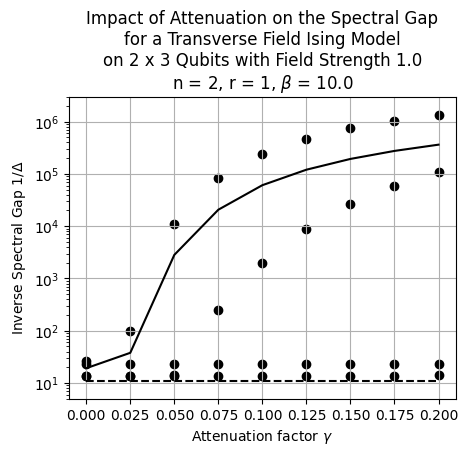

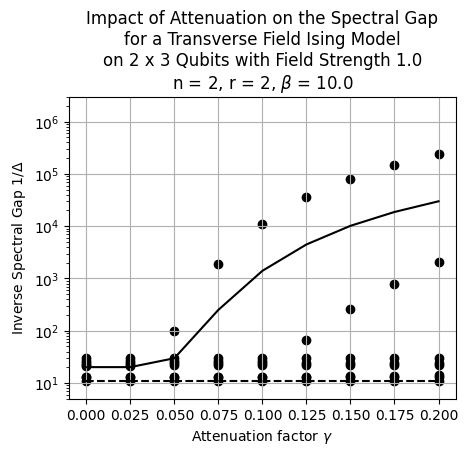

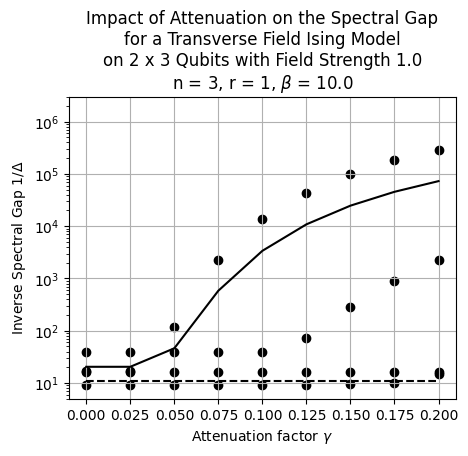

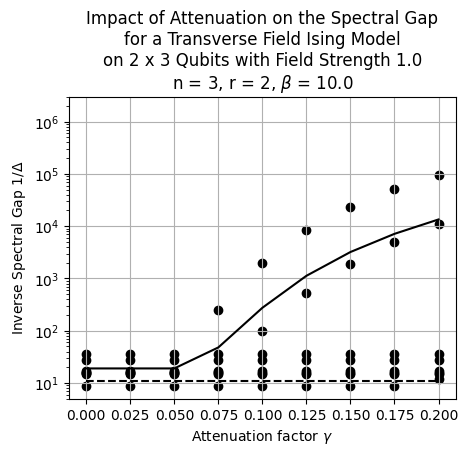

In [36]:
for beta in [10.0]:
    for n in [2,3]:
        for r in [1,2]:
            plt.figure(figsize=(5, 4), dpi=100)
            plot_mixing_times(2,3,1.0,n,r,beta,np.arange(0,0.225,0.025))
            plt.ylim(5,3e6)
            plt.savefig("export/attenuation_n{}_r{}_beta{}.pdf".format(n,r,beta))
            plt.show()